Notebook for harry testing

In [99]:
import sys
print(sys.executable)

/usr/local/bin/python3


In [100]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


# Imports / Data etc
!wget -q https://github.com/tinchit0/la-quiniela/raw/refs/heads/main/laliga.sqlite -O laliga.db
warnings.filterwarnings("ignore")

conn = sqlite3.connect('laliga.db')
df = pd.read_sql_query("SELECT * FROM Matches", conn)
df = df.dropna(axis = 'index' , how = 'all')
display(df.head())

# Close the connection when done
conn.close()

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


Now need to clean the data and process into usable features.  
  
Firslty, dropping rows with no score and then splitting score into home and away component.  
  
I think it also makes sense to use the final notation suggested in the assignment of: home_win = 1, away_win = 2, tie = X  
  

In [101]:
df = df.dropna(axis = 'index' , how = 'any', subset = 'score')
df['season'] = df['season'].str[:4].astype(int)
df[['home_score', 'away_score']] = df['score'].str.split(':', expand=True)
df['home_score'] = pd.to_numeric(df['home_score'])
df['away_score'] = pd.to_numeric(df['away_score'])
df = df[(~df['home_score'].isnull()) | (~df['away_score'].isnull())]

df['result'] = df.apply(lambda row: '1' if row['home_score'] > row['away_score']
                                        else '2' if row['home_score'] < row['away_score']
                                        else '0', axis=1)



-goals scores (at home and away)  
-goals conceded (at home and away)  
-goal difference  
-current ranking  
-average ranking in the last 5 seasons for example  
-current streak of games (average number of points gained in the last X games)  
-head2head (goals scored, conceded, wins, ties...)  
-general win/tie/loses rate of each team  
-Number of promotions and relegations ?  
-biggest win ?  
-longest undefeated streak ?  
-day and hour ?  

In [102]:
df['gd_5_game_home'] = None
df['gd_5_game_away'] = None
df['form_10_game_home'] = None
df['form_10_game_away'] = None

df['live_rank_home'] = None
df['live_rank_away'] = None

def calculate_gd_5_game(df):
    teams = df['home_team'].unique()
    for team in teams:
        team_df = df[(df['home_team'] == team) | (df['away_team'] == team)].copy()
        team_df['goal_difference'] = team_df.apply(
            lambda x: x['home_score'] - x['away_score'] if x['home_team'] == team else x['away_score'] - x['home_score'], axis=1
        )
        team_df['gd_5_game'] = team_df['goal_difference'].rolling(window=5).sum().shift(1)
        
        # Assign gd_5_game to the appropriate column based on home or away
        df.loc[team_df[team_df['home_team'] == team].index, 'gd_5_game_home'] = team_df.loc[team_df['home_team'] == team, 'gd_5_game']
        df.loc[team_df[team_df['away_team'] == team].index, 'gd_5_game_away'] = team_df.loc[team_df['away_team'] == team, 'gd_5_game']
    
    return df

def calculate_form_10_game(df):
    teams = df['home_team'].unique()
    for team in teams:
        team_df = df[(df['home_team'] == team) | (df['away_team'] == team)].copy()
        team_df['win'] = team_df.apply(
            lambda x: 1 if (x['home_team'] == team and x['home_score'] > x['away_score']) or 
                           (x['away_team'] == team and x['away_score'] > x['home_score']) else 0, axis=1
        )
        team_df['form_10_game'] = team_df['win'].rolling(window=10).sum().shift(1)
        
        # Assign form_10_game to the appropriate column based on home or away
        df.loc[team_df[team_df['home_team'] == team].index, 'form_10_game_home'] = team_df.loc[team_df['home_team'] == team, 'form_10_game']
        df.loc[team_df[team_df['away_team'] == team].index, 'form_10_game_away'] = team_df.loc[team_df['away_team'] == team, 'form_10_game']
    
    return df

# THIS FUNCTION NEEDS WORK
def calculate_live_rank(df):
    teams = df['home_team'].unique()
    points_table = {team: 0 for team in teams}
    matchdays = sorted(df['matchday'].unique())
    
    for matchday in matchdays:
        day_df = df[df['matchday'] == matchday]
        for _, row in day_df.iterrows():
            home_team, away_team = row['home_team'], row['away_team']
            home_score, away_score = row['home_score'], row['away_score']
            
            # Update points based on match result
            if home_score > away_score:
                points_table[home_team] += 3
            elif away_score > home_score:
                points_table[away_team] += 3
            else:
                points_table[home_team] += 1
                points_table[away_team] += 1
        
        # Sort teams by points and assign ranks
        sorted_teams = sorted(points_table.items(), key=lambda x: x[1], reverse=True)
        rank_dict = {team: rank+1 for rank, (team, _) in enumerate(sorted_teams)}
        
        # Update live rank for this matchday for both home and away teams
        for _, row in day_df.iterrows():
            df.loc[row.name, 'live_rank_home'] = rank_dict[row['home_team']]
            df.loc[row.name, 'live_rank_away'] = rank_dict[row['away_team']]
    
    return df


df = calculate_gd_5_game(df)
df = calculate_form_10_game(df)
df = calculate_live_rank(df)


display(df.head())
display(df.tail())


,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,result,gd_5_game_home,gd_5_game_away,form_10_game_home,form_10_game_away,live_rank_home,live_rank_away
0,1928,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3,2,3,2,NaN,NaN,NaN,NaN,78,67
1,1928,1,1,2/10/29,None,Espanyol,Real Unión,3:2,3,2,1,NaN,NaN,NaN,NaN,7,59
2,1928,1,1,2/10/29,None,Real Madrid,Catalunya,5:0,5,0,1,NaN,NaN,NaN,NaN,2,133
3,1928,1,1,2/10/29,None,Donostia,Athletic,1:1,1,1,0,NaN,NaN,NaN,NaN,99,6
4,1928,1,1,2/12/29,None,Racing,Barcelona,0:2,0,2,2,NaN,NaN,NaN,NaN,10,1


,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,result,gd_5_game_home,gd_5_game_away,form_10_game_home,form_10_game_away,live_rank_home,live_rank_away
48345,2021,2,3,8/28/21,10:00 PM,Ponferradina,Girona,2:1,2,1,1,-3.0,4.0,4.0,8.0,60,44
48346,2021,2,3,8/29/21,5:00 PM,SD Amorebieta,UD Almería,2:1,2,1,1,NaN,5.0,NaN,5.0,141,39
48347,2021,2,3,8/29/21,7:30 PM,CD Lugo,Real Valladolid,0:2,0,2,2,2.0,7.0,3.0,6.0,66,14
48348,2021,2,3,8/29/21,7:30 PM,Real Sociedad B,CF Fuenlabrada,0:0,0,0,0,NaN,1.0,NaN,4.0,126,86
48349,2021,2,3,8/29/21,10:00 PM,Burgos CF,SD Eibar,0:1,0,1,2,-4.0,-1.0,1.0,4.0,45,30


In [103]:
df['prev_season_rank_home'] = None
df['prev_season_rank_away'] = None

def calculate_season_ranks(df):

    prev_season_ranks = {}

    seasons = df['season'].unique()
    for season in seasons:

        season_df = df[df['season'] == season].copy()

        points_table = {}

        for _, row in season_df.iterrows():
            home_team, away_team = row['home_team'], row['away_team']
            home_score, away_score = row['home_score'], row['away_score']

            if home_team not in points_table:
                points_table[home_team] = 0
            if away_team not in points_table:
                points_table[away_team] = 0

            if home_score > away_score:
                points_table[home_team] += 3
            elif away_score > home_score:
                points_table[away_team] += 3
            else:
                points_table[home_team] += 1
                points_table[away_team] += 1

        ranked_teams = sorted(points_table.items(), key=lambda x: x[1], reverse=True)
        season_ranking = {team: rank+1 for rank, (team, _) in enumerate(ranked_teams)}

        for team, rank in season_ranking.items():
            prev_season_ranks[(season, team)] = rank
    
    return prev_season_ranks

prev_season_ranks = calculate_season_ranks(df)


def assign_prev_season_rank(df, prev_season_ranks):

    for i, row in df.iterrows():
        current_season = row['season']
        home_team = row['home_team']
        away_team = row['away_team']

        prev_season_year = current_season - 1

        df.at[i, 'prev_season_rank_home'] = prev_season_ranks.get((prev_season_year, home_team), None)
        df.at[i, 'prev_season_rank_away'] = prev_season_ranks.get((prev_season_year, away_team), None)
    
    return df

df = assign_prev_season_rank(df, prev_season_ranks)

display(df[['season', 'home_team', 'away_team', 'prev_season_rank_home', 'prev_season_rank_away']].head())
display(df.tail())


,season,home_team,away_team,prev_season_rank_home,prev_season_rank_away
0,1928,Arenas Club,Athletic Madrid,None,None
1,1928,Espanyol,Real Unión,None,None
2,1928,Real Madrid,Catalunya,None,None
3,1928,Donostia,Athletic,None,None
4,1928,Racing,Barcelona,None,None


,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,result,gd_5_game_home,gd_5_game_away,form_10_game_home,form_10_game_away,live_rank_home,live_rank_away,prev_season_rank_home,prev_season_rank_away
48345,2021,2,3,8/28/21,10:00 PM,Ponferradina,Girona,2:1,2,1,1,-3.0,4.0,4.0,8.0,60,44,15,9
48346,2021,2,3,8/29/21,5:00 PM,SD Amorebieta,UD Almería,2:1,2,1,1,NaN,5.0,NaN,5.0,141,39,None,8
48347,2021,2,3,8/29/21,7:30 PM,CD Lugo,Real Valladolid,0:2,0,2,2,2.0,7.0,3.0,6.0,66,14,26,41
48348,2021,2,3,8/29/21,7:30 PM,Real Sociedad B,CF Fuenlabrada,0:0,0,0,0,NaN,1.0,NaN,4.0,126,86,None,17
48349,2021,2,3,8/29/21,10:00 PM,Burgos CF,SD Eibar,0:1,0,1,2,-4.0,-1.0,1.0,4.0,45,30,None,42


In [104]:
y = df.loc[:,'result']

cols_to_drop = ['score','home_score','away_score','result', 'home_team', 'away_team']
X = df.drop(columns=cols_to_drop)
X = X.drop(columns=['date', 'time'])
print(X.columns)
y[:10,]

Index(['season', 'division', 'matchday', 'gd_5_game_home', 'gd_5_game_away',
       'form_10_game_home', 'form_10_game_away', 'live_rank_home',
       'live_rank_away', 'prev_season_rank_home', 'prev_season_rank_away'],
      dtype='object')


0    2
1    1
2    1
3    0
4    2
5    2
6    1
7    2
8    1
9    1
Name: result, dtype: object

In [105]:
X.corr().style.background_gradient("coolwarm", vmin=-1, vmax=1)

,season,division,matchday,gd_5_game_home,gd_5_game_away,form_10_game_home,form_10_game_away,live_rank_home,live_rank_away,prev_season_rank_home,prev_season_rank_away
season,1.000000,0.166222,0.215440,0.035376,-0.035882,-0.095221,-0.113715,0.061425,0.060052,0.310137,0.310090
division,0.166222,1.000000,0.090943,0.007467,-0.009946,-0.054974,-0.059584,0.519554,0.518272,0.291423,0.291641
matchday,0.215440,0.090943,1.000000,-0.001675,-0.007991,-0.038516,-0.042493,0.031621,0.029556,0.078387,0.081374
gd_5_game_home,0.035376,0.007467,-0.001675,1.000000,0.021001,0.629705,0.005106,-0.196376,-0.004374,-0.151387,0.006980
gd_5_game_away,-0.035882,-0.009946,-0.007991,0.021001,1.000000,0.018981,0.648366,-0.009036,-0.203986,-0.013658,-0.179089
form_10_game_home,-0.095221,-0.054974,-0.038516,0.629705,0.018981,1.000000,0.022146,-0.230346,-0.023006,-0.203977,-0.029424
form_10_game_away,-0.113715,-0.059584,-0.042493,0.005106,0.648366,0.022146,1.000000,-0.023858,-0.236434,-0.041323,-0.213121
live_rank_home,0.061425,0.519554,0.031621,-0.196376,-0.009036,-0.230346,-0.023858,1.000000,0.255570,0.203443,0.151022
live_rank_away,0.060052,0.518272,0.029556,-0.004374,-0.203986,-0.023006,-0.236434,0.255570,1.000000,0.150729,0.202901
prev_season_rank_home,0.310137,0.291423,0.078387,-0.151387,-0.013658,-0.203977,-0.041323,0.203443,0.150729,1.000000,0.144768


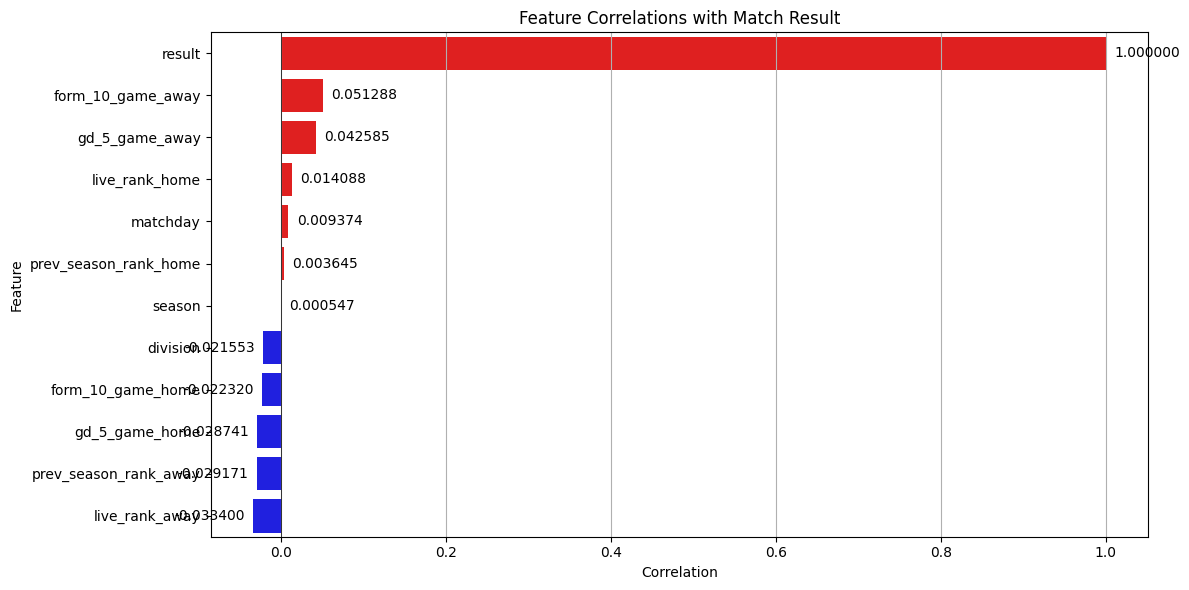


Correlations with match result:
              Feature  Correlation
               result     1.000000
    form_10_game_away     0.051288
       gd_5_game_away     0.042585
       live_rank_home     0.014088
             matchday     0.009374
prev_season_rank_home     0.003645
               season     0.000547
             division    -0.021553
    form_10_game_home    -0.022320
       gd_5_game_home    -0.028741
prev_season_rank_away    -0.029171
       live_rank_away    -0.033400

Feature importance (by absolute correlation):
              Feature  Correlation  Absolute Correlation
               result     1.000000              1.000000
    form_10_game_away     0.051288              0.051288
       gd_5_game_away     0.042585              0.042585
       live_rank_away    -0.033400              0.033400
prev_season_rank_away    -0.029171              0.029171
       gd_5_game_home    -0.028741              0.028741
    form_10_game_home    -0.022320              0.022320
         

In [106]:
cols_to_drop = ['date', 'time', 'score','home_score','away_score', 'home_team', 'away_team']
X = df.drop(columns=cols_to_drop)
X['result'] = pd.to_numeric(X['result'])

# Calculate correlations with result
correlations = X.corr()['result'].sort_values(ascending=False)

# Create a DataFrame for visualization
corr_df = pd.DataFrame({'Feature': correlations.index, 
                       'Correlation': correlations.values})

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=corr_df, 
            y='Feature',
            x='Correlation',
            palette=['red' if x > 0 else 'blue' for x in corr_df['Correlation']])

plt.title('Feature Correlations with Match Result')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, axis='x')

# Add correlation values on the bars
for i, v in enumerate(corr_df['Correlation']):
    plt.text(v + (0.01 if v >= 0 else -0.01), 
             i,
             f'{v:.6f}',
             va='center',
             ha='left' if v >= 0 else 'right')

plt.tight_layout()
plt.show()

# Print correlations in order
print("\nCorrelations with match result:")
print(corr_df.to_string(index=False))

# Optional: Calculate feature importance using absolute values
print("\nFeature importance (by absolute correlation):")
importance_df = corr_df.copy()
importance_df['Absolute Correlation'] = abs(importance_df['Correlation'])
importance_df = importance_df.sort_values('Absolute Correlation', ascending=False)
print(importance_df.to_string(index=False))

              precision    recall  f1-score   support

           0       0.36      0.02      0.04      2453
           1       0.54      0.95      0.69      5018
           2       0.45      0.14      0.22      2129

    accuracy                           0.54      9600
   macro avg       0.45      0.37      0.32      9600
weighted avg       0.48      0.54      0.42      9600



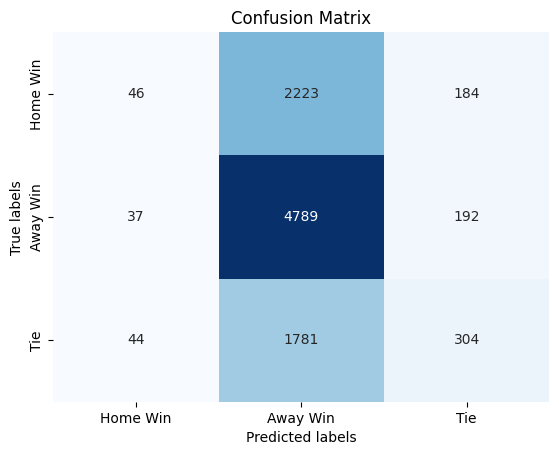

In [107]:
#X = pd.get_dummies(X, columns=['home_team','away_team'])
X = X.drop(columns = ['result'])
X = X.replace(np.nan, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
models_performance = pd.DataFrame(columns=['model', 'accuracy'])

def performance(y_test, y_pred, model):
    # Classificatin Report shows some metrics to evaluate the model performance
    class_report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    accuracy = class_report['accuracy']

    # Plot Confusion Matrix
    labels = ["Home Win", "Away Win", "Tie"]
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_accuracy = performance(y_test, gb_pred, gb_model)
models_performance.loc[len(models_performance)] = ['Gradient Boosting', gb_accuracy]

              precision    recall  f1-score   support

           0       0.37      0.01      0.01      2453
           1       0.53      0.97      0.69      5018
           2       0.38      0.08      0.13      2129

    accuracy                           0.52      9600
   macro avg       0.43      0.35      0.28      9600
weighted avg       0.46      0.52      0.39      9600



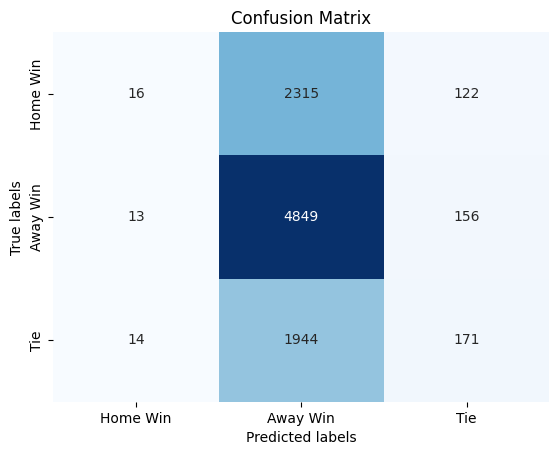

In [108]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
LR_pred = LR_model.predict(X_test)
LR_accuracy = performance(y_test, LR_pred, LR_model)
models_performance.loc[len(models_performance)] = ['Logistic Regression', LR_accuracy]

              precision    recall  f1-score   support

           0       0.30      0.12      0.18      2453
           1       0.56      0.82      0.66      5018
           2       0.36      0.21      0.26      2129

    accuracy                           0.51      9600
   macro avg       0.40      0.38      0.37      9600
weighted avg       0.45      0.51      0.45      9600



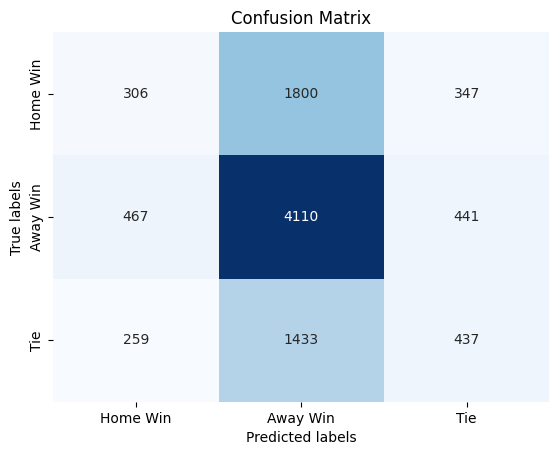

In [109]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)
NB_pred = NB_model.predict(X_test)
NB_accuracy = performance(y_test, NB_pred, NB_model)
models_performance.loc[len(models_performance)] = ['Naive Bayes', NB_accuracy]

              precision    recall  f1-score   support

           0       0.29      0.33      0.31      2453
           1       0.56      0.67      0.61      5018
           2       0.34      0.14      0.20      2129

    accuracy                           0.47      9600
   macro avg       0.40      0.38      0.37      9600
weighted avg       0.44      0.47      0.44      9600



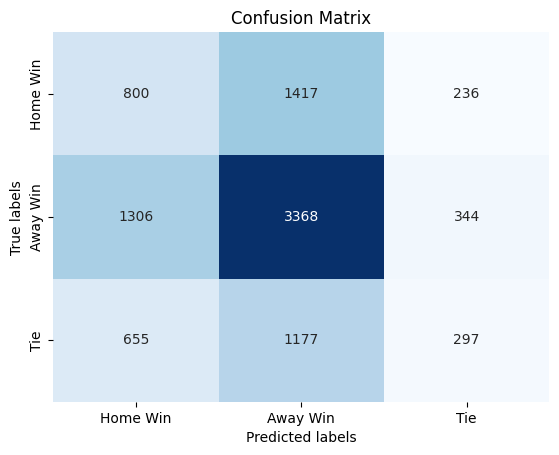

In [110]:
kNN_model = KNeighborsClassifier()
kNN_model.fit(X_train, y_train)
kNN_pred = kNN_model.predict(X_test)
kNN_accuracy = performance(y_test, kNN_pred, kNN_model)
models_performance.loc[len(models_performance)] = ['k Nearest Neighbors', kNN_accuracy]

              precision    recall  f1-score   support

           0       0.27      0.29      0.28      2453
           1       0.56      0.55      0.55      5018
           2       0.27      0.27      0.27      2129

    accuracy                           0.42      9600
   macro avg       0.37      0.37      0.37      9600
weighted avg       0.42      0.42      0.42      9600



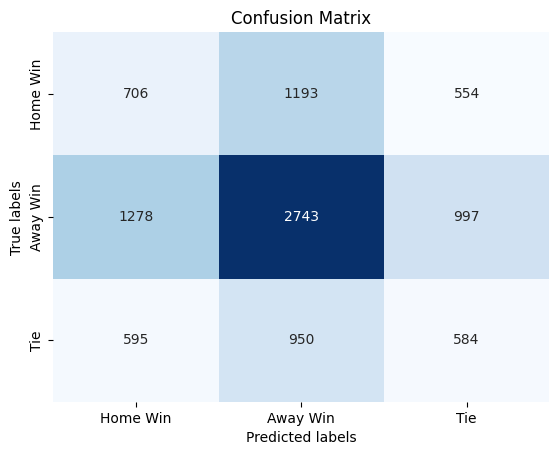

In [115]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
tree_accuracy = performance(y_test, tree_pred, tree_model)
models_performance.loc[len(models_performance)] = ['Decision Trees', tree_accuracy]

              precision    recall  f1-score   support

           0       0.29      0.12      0.17      2453
           1       0.55      0.86      0.67      5018
           2       0.36      0.14      0.20      2129

    accuracy                           0.51      9600
   macro avg       0.40      0.37      0.35      9600
weighted avg       0.44      0.51      0.44      9600



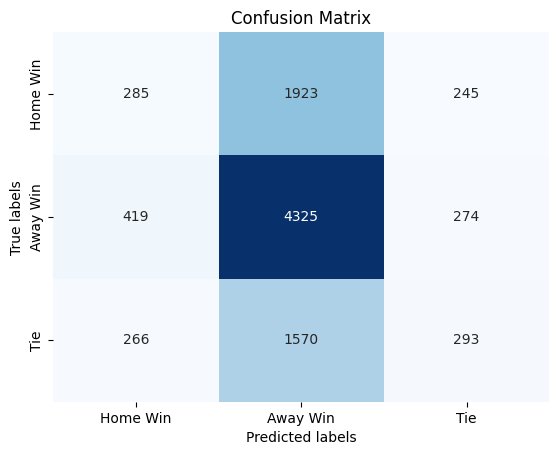

In [116]:
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
RF_accuracy = performance(y_test, RF_pred, RF_model)
models_performance.loc[len(models_performance)] = ['Random Forest', RF_accuracy]

In [117]:
models_performance = models_performance.sort_values(['accuracy'], ascending=False)
print(models_performance)

                 model  accuracy
0    Gradient Boosting  0.535312
1  Logistic Regression  0.524583
5        Random Forest  0.516458
7        Random Forest  0.510729
2          Naive Bayes  0.505521
3  k Nearest Neighbors  0.465104
6       Decision Trees  0.420104
4       Decision Trees  0.418229


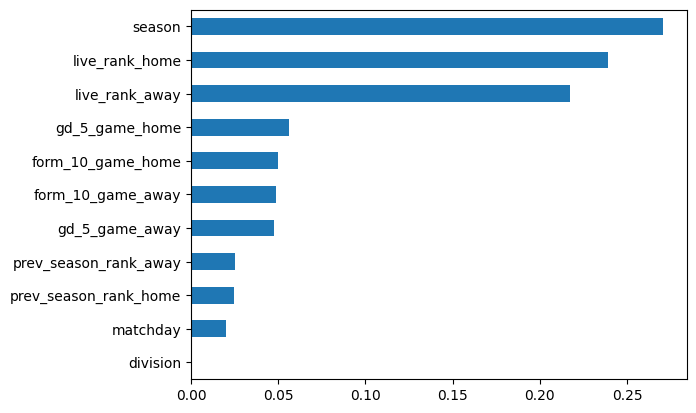

In [118]:
# Get the feature importance of the model
feature_imp = gb_model.feature_importances_

# Get the top 20 features
indices = np.argsort(feature_imp)[-20:][::-1]
feature_names = X.columns
feature_names = feature_names[indices]

# Plot
importances = pd.Series(feature_imp[indices], index=feature_names)
importances.sort_values(ascending=True).plot(kind="barh")
plt.show()